Importing all the required modules

In [1]:
import torch 
from torch import nn
from torchvision import transforms,models
from torch.utils.data import DataLoader,Dataset
from torchvision.datasets import ImageFolder
from torchsummary import summary
from tqdm import tqdm
import numpy as np

c:\Users\Samba\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\Samba\AppData\Local\Programs\Python\Python39\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


Setting up the computing environment

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device using: ',device)

Device using:  cuda


Name of GPU:

In [3]:
torch.cuda.get_device_name()

'NVIDIA GeForce GTX 1050'

### Dataset

In [4]:
dataset = ImageFolder('dataset',transform=transforms.Compose([transforms.Resize((28,28)),transforms.ToTensor()]))
len(dataset)

66831

In [5]:
o = lambda i,k,p=0,s=1: (i+2*p-k)//s +1 
o(5,3)

3

In [6]:
class Cnet(nn.Module):
    def __init__(self) -> None:
        super(Cnet,self).__init__()
        self.convlayers = nn.Sequential(
                nn.Conv2d(3,8,(5,5),(1,1),padding=0),
                nn.ReLU(), # max(0,x)
                nn.MaxPool2d(2,2,0),#12

                nn.Conv2d(8,16,3,1,0),#10
                nn.ReLU(),
                nn.MaxPool2d(2,2,0),#5

                nn.Conv2d(16,32,3,1,0),
                nn.ReLU()      #4          
        )
        self.classifier = nn.Sequential(
            nn.Linear(in_features=9*32,out_features=256,bias=True),
            nn.ReLU(),
            nn.Linear(256,66,bias=True)
        )
    
    def forward(self,x):
        x = self.convlayers(x)
        x = torch.flatten(x,1)
        x = self.classifier(x)
        # x = self.classifier(x.view(-1,16*32))
        return x

In [7]:
model = Cnet()
model

Cnet(
  (convlayers): Sequential(
    (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=288, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=66, bias=True)
  )
)

In [8]:
summary(model.cuda(),(3,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 24, 24]             608
              ReLU-2            [-1, 8, 24, 24]               0
         MaxPool2d-3            [-1, 8, 12, 12]               0
            Conv2d-4           [-1, 16, 10, 10]           1,168
              ReLU-5           [-1, 16, 10, 10]               0
         MaxPool2d-6             [-1, 16, 5, 5]               0
            Conv2d-7             [-1, 32, 3, 3]           4,640
              ReLU-8             [-1, 32, 3, 3]               0
            Linear-9                  [-1, 256]          73,984
             ReLU-10                  [-1, 256]               0
           Linear-11                   [-1, 66]          16,962
Total params: 97,362
Trainable params: 97,362
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/ba

In [9]:
criterion = nn.CrossEntropyLoss()
learning_rate = 3e-4
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

In [10]:
trainsize = int(len(dataset)*0.8)
testsize = len(dataset)-trainsize
trainset,testset = torch.utils.data.random_split(dataset,[trainsize,testsize])
len(trainset),len(testset)

(53464, 13367)

In [11]:
def training_process(model,device,trainloader,criterion,optimizer,valoader):
    model.train()
    running_loss  = 0
    Ncorrect_predictions = 0 # number of correct prediction
    total = 0
    for images,labels in tqdm(trainloader):
        images,labels = images.to(device), labels.to(device)
        # moving the data to GPU
        optimizer.zero_grad()
        out = model(images)
        loss_per_batch = criterion(out,labels)
        total += labels.size(0) # basically this should return the batch size
        preds = torch.argmax(out,1).cpu().detach()
        running_loss +=loss_per_batch.item()
        Ncorrect_predictions += (preds==labels.cpu().detach()).sum().item()
        
        loss_per_batch.backward() # back propagation algorithm it 
        optimizer.step() 

    acc = 100*(Ncorrect_predictions/total)
    avg_loss = running_loss/len(trainloader)

    model.eval()
    total_ = 0
    correct_ = 0
    running_loss_ = 0
    with torch.no_grad():
        for images,labels in tqdm(valoader):
            out = model(images.to(device))
            labels = labels.to(device)
            loss = criterion(out,labels)
            running_loss_ += loss.item() 
            total_ += labels.size(0)
            predictions = out.argmax(dim=1).cpu().detach()
            correct_ += (predictions==labels.cpu().detach()).sum().item()
    
    val_loss = running_loss_/len(valoader)
    val_acc = 100*(correct_/total_)

    return acc,avg_loss,val_loss,val_acc

    

In [12]:
trainloader = DataLoader(trainset,batch_size=16,shuffle=True,num_workers=4)
valloader = DataLoader(testset,batch_size=16,shuffle=False,num_workers=4)

100%|██████████| 836/836 [00:13<00:00, 60.11it/s] 


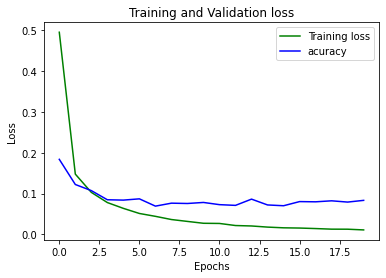

In [13]:

import matplotlib.pyplot as plt
%matplotlib inline
accuracy=[]
loss=[]
vloss=[]
vacc=[]

for epoch in range(20):
    a,l,vl,va = training_process(model,device,trainloader,criterion,optimizer,valloader)
    accuracy.append(a)
    loss.append(l)
    vloss.append(vl)
    vacc.append(va)

epochs = range(20)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs,vloss , 'b', label='acuracy')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

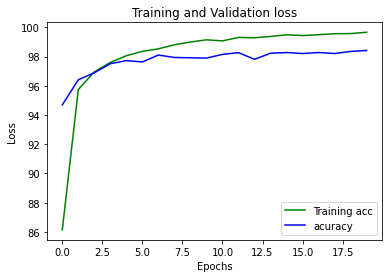

In [17]:
epochs = range(20)
plt.plot(epochs, accuracy, 'g', label='Training acc')
plt.plot(epochs,vacc , 'b', label='acuracy')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
accuracy,vacc

([86.13459524165793,
  95.7485410743678,
  96.95683076462667,
  97.60399521173126,
  98.06037707616339,
  98.35964387251235,
  98.53359269789017,
  98.81041448451295,
  98.99932664970822,
  99.15083046535987,
  99.0778841837498,
  99.31355678587461,
  99.29111177614843,
  99.38089181505312,
  99.49311686368397,
  99.44261559180009,
  99.49872811611552,
  99.5698039802484,
  99.57728565015711,
  99.66893610653898],
 [94.69589287050198,
  96.41654821575521,
  96.89533926834743,
  97.51627141467793,
  97.72574250018702,
  97.63596917782598,
  98.10727912022143,
  97.94269469589287,
  97.92025136530262,
  97.89780803471236,
  98.15216578140196,
  98.27186354455002,
  97.81551582254806,
  98.23445799356625,
  98.27934465474677,
  98.21201466297599,
  98.27934465474677,
  98.21201466297599,
  98.3541557567143,
  98.42148574848507])

In [19]:
def save_model(path):
    torch.save(model.state_dict(),path)

In [20]:
# save_model('trainedmodel/model.pth')

In [22]:
torch.set_printoptions(threshold=10_000)

dataset[0][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [14]:
# from PIL import Image 
# import numpy as np
# x = Image.open('apple0.jpg')
# x=x.convert('L')
# y = np.asarray(x)
# print(y.shape)
# # x.show()
# x1 = x.resize((34,34))
# # x1.show()
# x1 = torch.from_numpy(np.asarray(x1))
# x1 = x1.unsqueeze(0)
# x1 = x1.unsqueeze(0)
# print(x1.shape)
# x1=x1.float().to(device)
# print(type(x1),device)
# out = model(x1)
# print(dataset.classes[out.argmax(1).item()])
# out = nn.functional.softmax(out,1)
# print(dataset.classes[out.argmax(1).item()])


In [15]:
# import cv2 
# x = cv2.imread('../apple0.jpg')
# print(x.shape)
# hsv = cv2.cvtColor(x,cv2.COLOR_BGR2HSV)
# mask = cv2.inRange(hsv,np.array([0,0,250]),np.array([172,111,255]))
# # _, thresh = cv2.threshold(y,250,255,0)
# contours, _ = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
# cv2.drawContours(x,contours,-1,(0,255,255),3)
# cv2.imshow('out',x)
# print(contours,a)

In [16]:
# def apply_kernel(image, kernel):
#     ri, ci = image.shape       # image dimensions
#     rk, ck = kernel.shape      # kernel dimensions
#     ro, co = ri-rk+1, ci-ck+1  # output dimensions
#     output = torch.zeros([ro, co])
#     for i in range(ro): 
#         for j in range(co):
#             output[i,j] = torch.sum(image[i:i+rk,j:j+ck] * kernel)
#     return output